In [1]:
import os
from netCDF4 import Dataset
from remap import remap
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
import numpy as np
from cpt_convert import loadCPT
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

In [27]:
PATH = 'dados/'
DAY = 1
MONTH = 1
YEAR = 2019
time = 5

In [28]:
path = PATH+str(YEAR)+'/'+str(MONTH)+'/'+str(DAY)+'/'+str(os.listdir(PATH+'/'+str(YEAR)+'/'+str(MONTH)+'/'+str(DAY))[time])

In [29]:
# Getting information from the file name ==============================================================
# Search for the Scan start in the file name
Start = (path[path.find("_s")+2:path.find("_e")])
# Search for the GOES-16 channel in the file name
Band = int((path[path.find("M3C" or "M4C")+3:path.find("_G16")]))
# Create a GOES-16 Bands string array
Wavelenghts = ['[]','[0.47 μm]','[0.64 μm]','[0.865 μm]','[1.378 μm]','[1.61 μm]','[2.25 μm]','[3.90 μm]','[6.19 μm]','[6.95 μm]','[7.34 μm]','[8.50 μm]','[9.61 μm]','[10.35 μm]','[11.20 μm]','[12.30 μm]','[13.30 μm]']
time = Start [7:9] + ":" + Start [9:11] + ":" + Start [11:13] + " UTC" # Time of the Start of the Scan

In [30]:
try:
    nc = Dataset(path)
except Exception as e:
    print('File not found')

In [31]:
# Get the latitude and longitude image bounds
geo_extent = nc.variables['geospatial_lat_lon_extent']
min_lon = float(geo_extent.geospatial_westbound_longitude)
max_lon = float(geo_extent.geospatial_eastbound_longitude)
min_lat = float(geo_extent.geospatial_southbound_latitude)
max_lat = float(geo_extent.geospatial_northbound_latitude)

In [32]:
# Choose the visualization extent (min lon, min lat, max lon, max lat)
# Sao Paulo
extent = [-53.110112, -25.358, -44.161365, -19.779656]
# Choose the image resolution (the higher the number the faster the processing is)
resolution = 2.0

Unit = "Reflectance"

In [33]:
# Choose a title for the plot
Title = " GOES-16 ABI CMI Band " + str(Band) + " " + Wavelenghts[int(Band)] + " " + Unit + " " + " " + time
# Insert the institution name
Institution = "GNC-A Blog"
# =====================================================================================================

In [34]:
# Call the reprojection funcion
grid = remap(path, extent, resolution, 'NETCDF')

Remapping dados/2019/1/1/OR_ABI-L2-CMIPF-M3C11_G16_s20190011845363_e20190011856130_c20190011856220.nc
- finished! Time: 0.07066059112548828 seconds


In [35]:
data = grid.ReadAsArray()
data.shape

(310, 498)

Text(-44.161365, -25.341264968, 'GNC-A Blog')

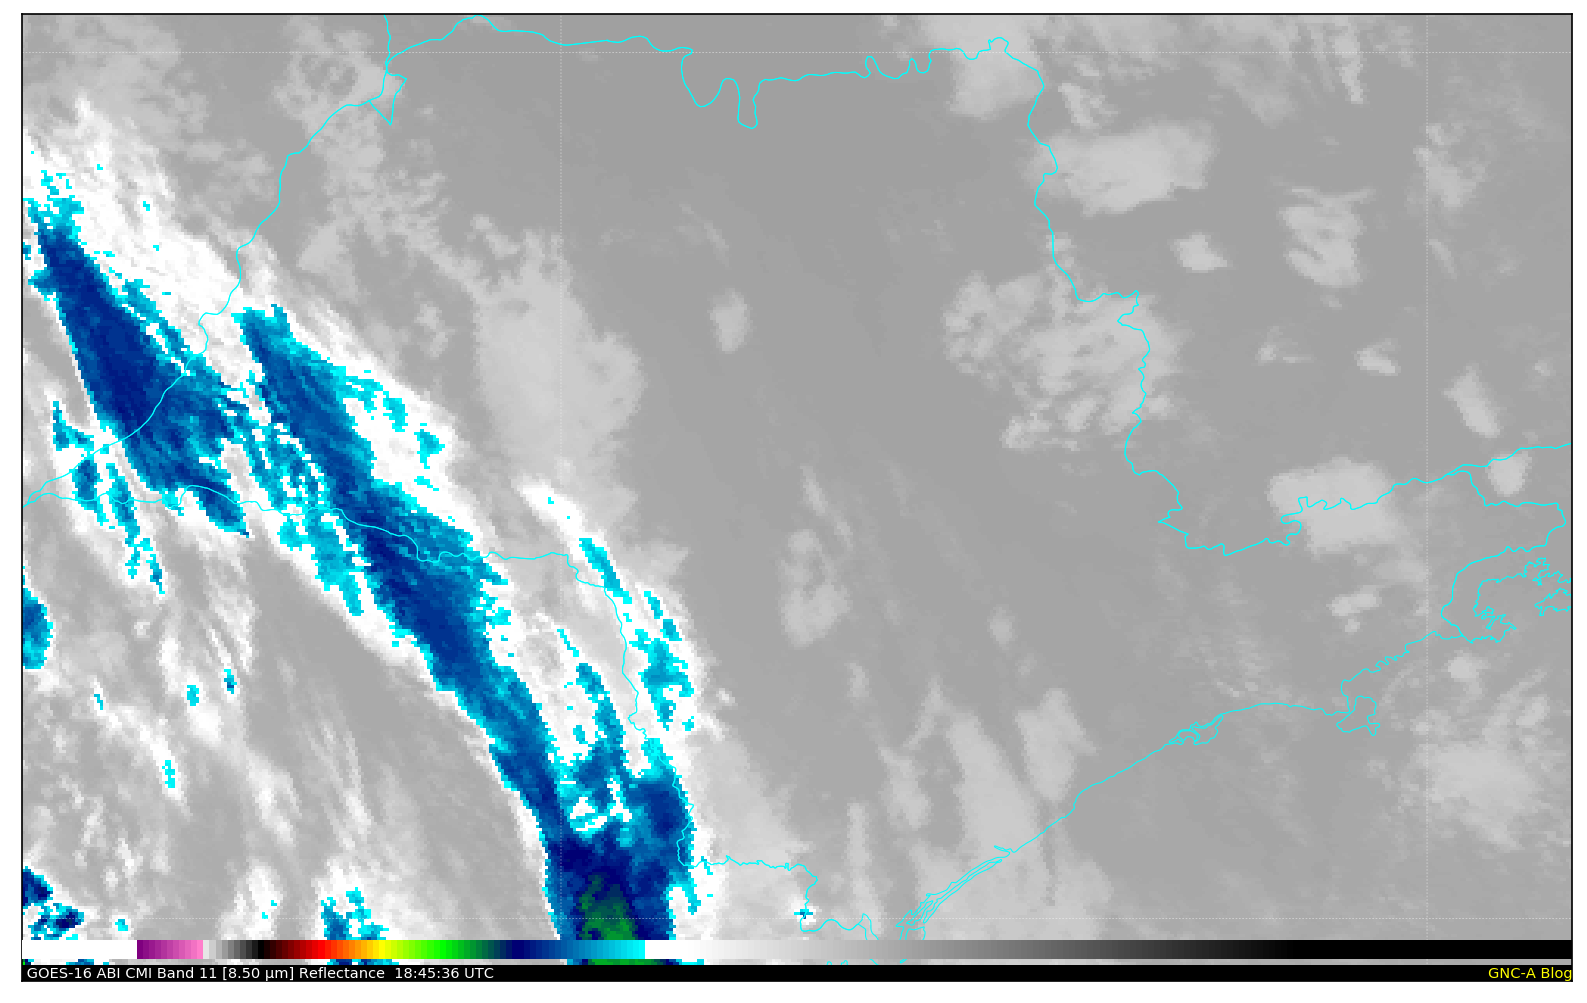

In [38]:
# Define the size of the saved picture=================================================================
DPI = 150
ax = plt.figure(figsize=(2000/float(DPI), 2000/float(DPI)), frameon=True, dpi=DPI)
#======================================================================================================

# Plot the Data =======================================================================================
# Create the basemap reference for the Rectangular Projection
bmap = Basemap(llcrnrlon=extent[0], llcrnrlat=extent[1], urcrnrlon=extent[2], urcrnrlat=extent[3], epsg=4326)

# Draw Shapefile
bmap.readshapefile('shapes/Brazilian_States_Shape/BRA_adm1','BRA_adm1',linewidth=0.50,color='cyan')

# Draw parallels and meridians
bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.2, dashes=[4, 4], color='white', labels=[False,False,False,False], fmt='%g', labelstyle="+/-", xoffset=-0.80, yoffset=-1.00, size=7)
bmap.drawmeridians(np.arange(0.0, 360.0, 5.0), linewidth=0.2, dashes=[4, 4], color='white', labels=[False,False,False,False], fmt='%g', labelstyle="+/-", xoffset=-0.80, yoffset=-1.00, size=7)
# bmap.drawmapboundary(fill_color='lightgrey')


cpt = loadCPT('Colortables/IR4AVHRR6.cpt')
# Makes a linear interpolation
cpt_convert = LinearSegmentedColormap('cpt', cpt)

# Plot the GOES-16 channel with the converted CPT colors (you may alter the min and max to match your preference)
bmap.imshow(data, origin='upper', cmap=cpt_convert, vmin=170, vmax=378)
 
cb = bmap.colorbar(location='bottom', size = '2%', pad = '-4.2%', ticks=[0.2, 0.4, 0.6, 0.8])
cb.ax.set_xticklabels(['0.2', '0.4', '0.8', '0.8'])
cb.outline.set_visible(False)
cb.ax.tick_params(width = 0)
cb.ax.xaxis.set_tick_params(pad=-9.5)
cb.ax.tick_params(axis='x', colors='yellow', labelsize=6)

# Add a black rectangle in the bottom to insert the image description
lon_difference = (extent[2] - extent[0]) # Max Lon - Min Lon
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((extent[0], extent[1]), lon_difference, lon_difference * 0.010, alpha=1, zorder=3, facecolor='black'))

# Add the image description inside the black rectangle
lat_difference = (extent[3] - extent[1]) # Max lat - Min lat
plt.text(extent[0], extent[1] + lat_difference * 0.003,Title,horizontalalignment='left', color = 'white', size=7)
plt.text(extent[2], extent[1] + lat_difference * 0.003,Institution, horizontalalignment='right', color = 'yellow', size=7)